In [8]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

In [9]:
dataset_path = 'D:/project/deep_learning Project/emotion/TESS Toronto emotional speech set data'
paths, labels = [], []

In [10]:
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1].split('.')[0].lower()
        labels.append(label)

In [11]:
df = pd.DataFrame({'speech': paths, 'label': labels})

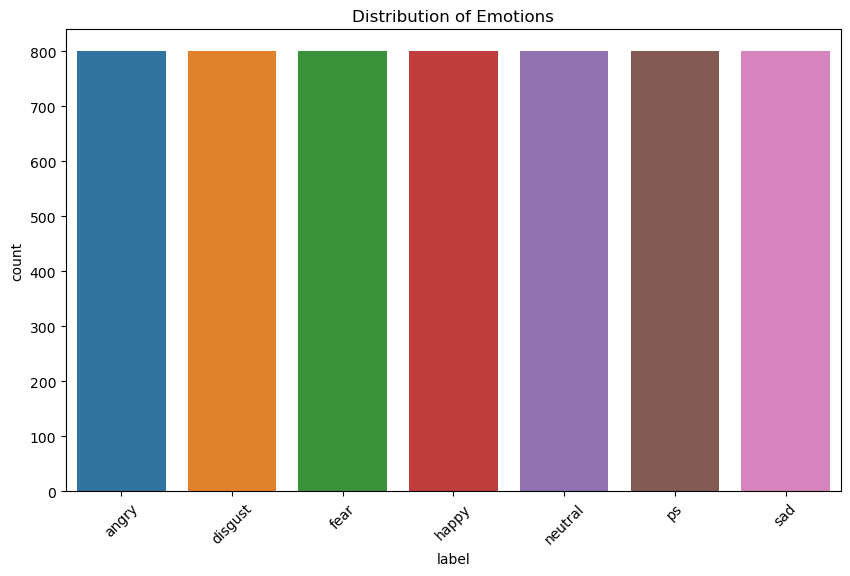

In [12]:
# Check distribution of data
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Extract MFCC features
def extract_mfcc(filename):
    try:
        y, sr = librosa.load(filename, duration=3, offset=0.5)
        # Data augmentation
        y_stretch = librosa.effects.time_stretch(y, rate=0.8)
        y_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)  # Fixed the pitch_shift function call
        
        mfcc_original = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        mfcc_stretch = np.mean(librosa.feature.mfcc(y=y_stretch, sr=sr, n_mfcc=40).T, axis=0)
        mfcc_shift = np.mean(librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=40).T, axis=0)
        
        # Return concatenated MFCCs from original and augmented data
        return mfcc_original, mfcc_stretch, mfcc_shift
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return np.zeros((40,)), np.zeros((40,)), np.zeros((40,))

In [14]:
# Extract features from all files
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [15]:
# Extract original and augmented data
X = np.array([x[0] for x in X_mfcc])  # Original MFCC
X_stretch = np.array([x[1] for x in X_mfcc])  # Time-stretched MFCC
X_shift = np.array([x[2] for x in X_mfcc])  # Pitch-shifted MFCC

In [16]:
# Combine original and augmented data
X_combined = np.concatenate((X, X_stretch, X_shift), axis=0)
y_combined = np.concatenate([df['label'], df['label'], df['label']], axis=0)

In [17]:
# Normalize the MFCC features
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined)

In [18]:
# Expand dimensions to make it compatible with LSTM
X_combined = np.expand_dims(X_combined, -1)

In [19]:
# Encode labels
enc = OneHotEncoder()
y_combined_encoded = enc.fit_transform(y_combined.reshape(-1, 1)).toarray()

In [20]:
# Model building with LSTM or GRU layers and Batch Normalization
model = Sequential([
    GRU(256, return_sequences=True, input_shape=(40, 1)),  # You can switch to LSTM if needed
    BatchNormalization(),
    Dropout(0.3),
    GRU(128),  # Or use LSTM
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_combined_encoded.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\adity\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 40, 256)             │         198,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 373,895 (1.43 MB)

 Trainable params: 373,127 (1.42 MB)

 Non-trainable params: 768 (3.00 KB)

In [21]:
# Calculate class weights to handle data imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_combined), y=y_combined)
class_weights_dict = dict(enumerate(class_weights))

In [22]:
# Set up callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [23]:
# Train the model
history = model.fit(X_combined, y_combined_encoded, validation_split=0.2, epochs=30, batch_size=32,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 133s 298ms/step - accuracy: 0.6000 - loss: 1.0614 - val_accuracy: 0.6071 - val_loss: 1.7842 - learning_rate: 0.0010
Epoch 2/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 135s 321ms/step - accuracy: 0.9272 - loss: 0.2294 - val_accuracy: 0.7420 - val_loss: 0.9768 - learning_rate: 0.0010
Epoch 3/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 161s 383ms/step - accuracy: 0.9489 - loss: 0.1676 - val_accuracy: 0.7125 - val_loss: 1.6370 - learning_rate: 0.0010
Epoch 4/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 167s 396ms/step - accuracy: 0.9650 - loss: 0.1191 - val_accuracy: 0.7860 - val_loss: 0.8318 - learning_rate: 0.0010
Epoch 5/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 149s 356ms/step - accuracy: 0.9624 - loss: 0.1268 - val_accuracy: 0.7893 - val_loss: 1.2116 - learning_rate: 0.0010
Epoch 6/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 140s 334ms/step - accuracy: 0.9757 - loss: 0.0806 - val_accuracy: 0.7756 - val_loss: 1.2506 - learning_rate: 0.0010
Epoch 7/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 162s 386ms/step - accura

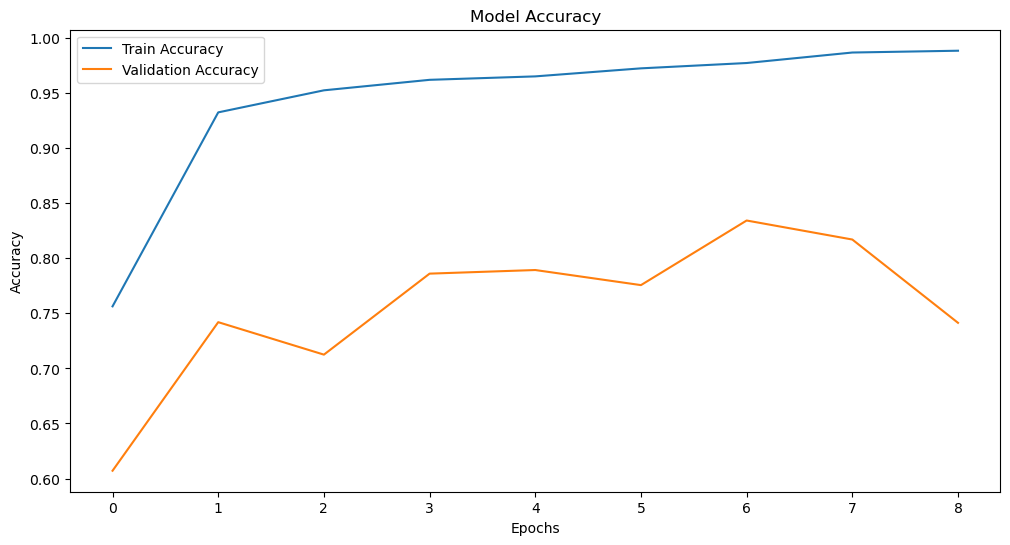

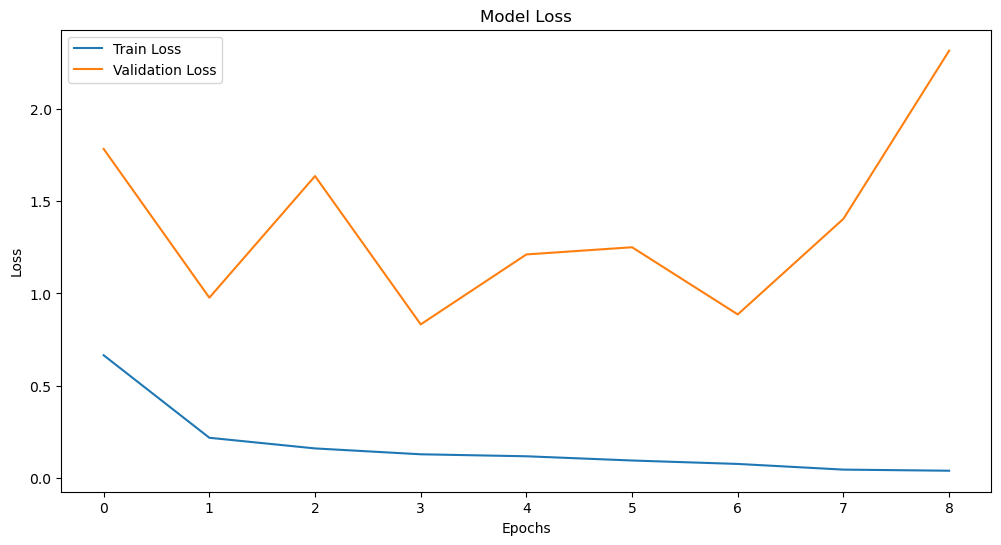

In [24]:
# Plot accuracy and loss
epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Evaluate the model using the training data (this is only for demonstration purposes; in a real scenario, you should use a separate test set)
y_pred = model.predict(X_combined)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_combined_encoded, axis=1)

525/525 ━━━━━━━━━━━━━━━━━━━━ 81s 142ms/step


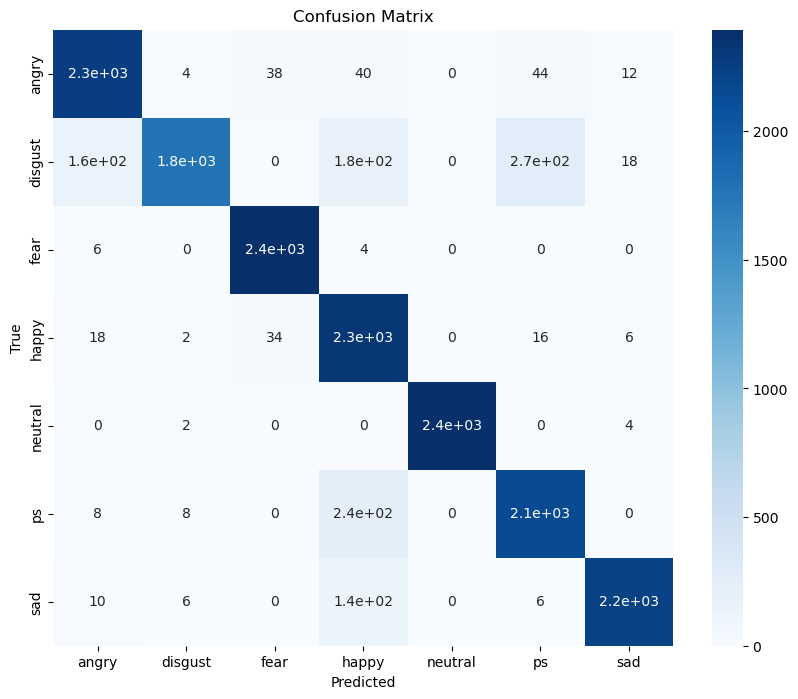

In [26]:
# Confusion matrix and classification report
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
print(classification_report(y_true, y_pred_classes, target_names=enc.categories_[0]))

              precision    recall  f1-score   support

       angry       0.92      0.94      0.93      2400
     disgust       0.99      0.74      0.85      2400
        fear       0.97      1.00      0.98      2400
       happy       0.80      0.97      0.87      2400
     neutral       1.00      1.00      1.00      2400
          ps       0.87      0.89      0.88      2400
         sad       0.98      0.93      0.96      2400

    accuracy                           0.92     16800
   macro avg       0.93      0.92      0.92     16800
weighted avg       0.93      0.92      0.92     16800



In [28]:
model.save('emotion_recognition_model.keras')

In [29]:
from keras.models import load_model
model = load_model('emotion_recognition_model.keras')

In [30]:
# Reshape X_combined to 2D (samples, 40) for scaling
X_combined_2d = X_combined.reshape(X_combined.shape[0], -1)

# Normalize the MFCC features using the scaler
X_combined_scaled = scaler.fit_transform(X_combined_2d)

# Reshape back to (samples, 40, 1) for model compatibility
X_combined = np.expand_dims(X_combined_scaled, -1)


In [31]:
def predict_emotion(audio_file_path):
    try:
        # Extract MFCC features from the new audio file
        mfcc_features = extract_mfcc(audio_file_path)[0]  # We take the original MFCCs
        mfcc_features = scaler.transform([mfcc_features])  # Scale using the scaler trained on training data
        mfcc_features = np.expand_dims(mfcc_features, -1)  # Reshape to (1, 40, 1) for prediction
        
        # Make prediction
        prediction = model.predict(mfcc_features)
        predicted_label = enc.inverse_transform(prediction)[0][0]
        
        print(f"Predicted Emotion for {audio_file_path}: {predicted_label}")
        return predicted_label
    except Exception as e:
        print(f"Error predicting emotion for {audio_file_path}: {e}")
        return None



In [32]:
# Test the prediction function
test_audio_file = "D:/project/deep_learning Project/emotion/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_book_ps.wav"
predicted_emotion = predict_emotion(test_audio_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Emotion for D:/project/deep_learning Project/emotion/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_book_ps.wav: neutral
